# Importation de l'image et des Libraries

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Chargement de l'image
image_path = r'Z:\Study\MrSoualah\TP2-A-Remettre\img\1.png'  # Chemin vers l'image manuscrite
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"L'image n'a pas été trouvée au chemin : {image_path}")

# Introduction & Prétraitement

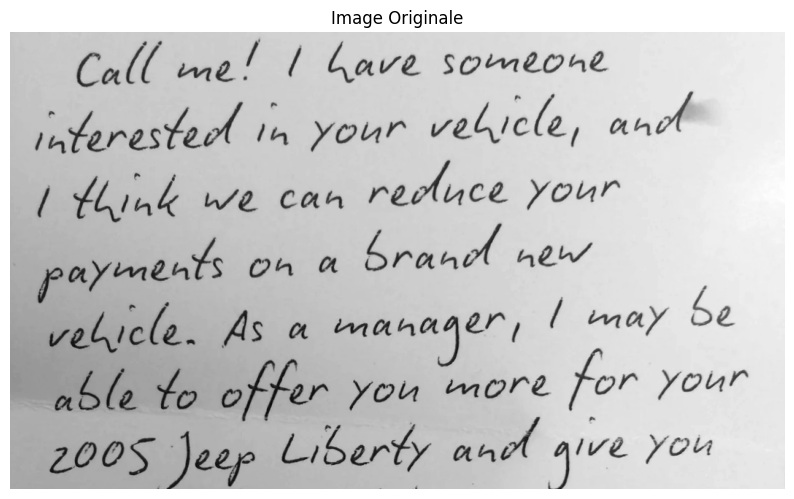

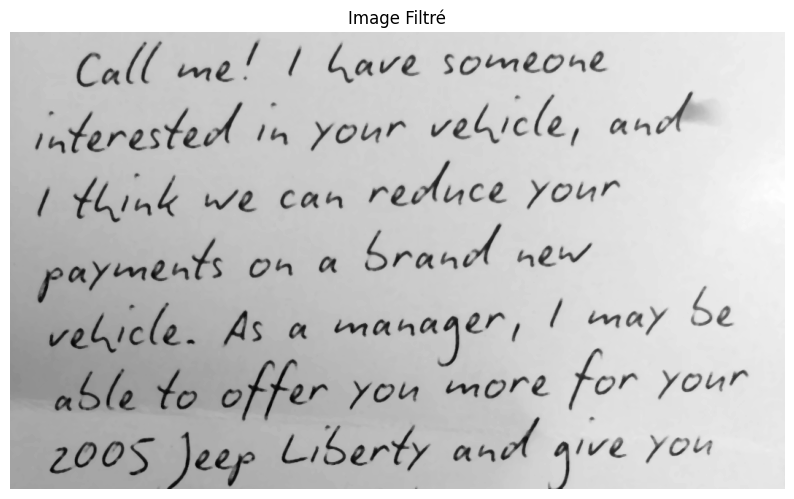

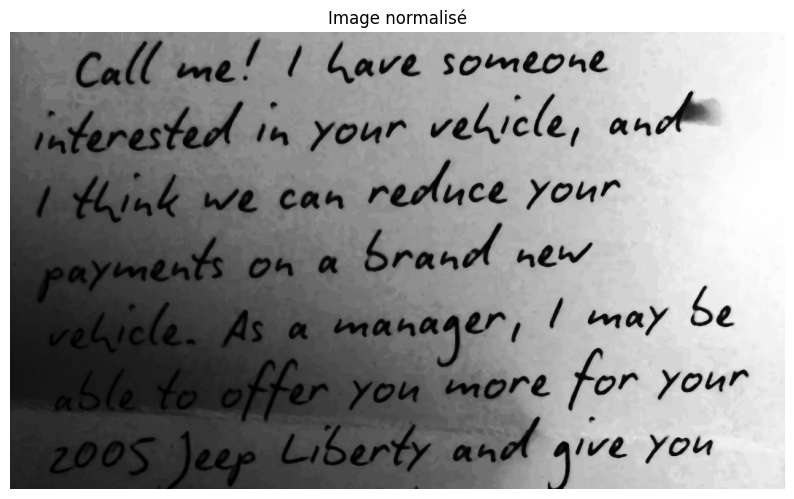

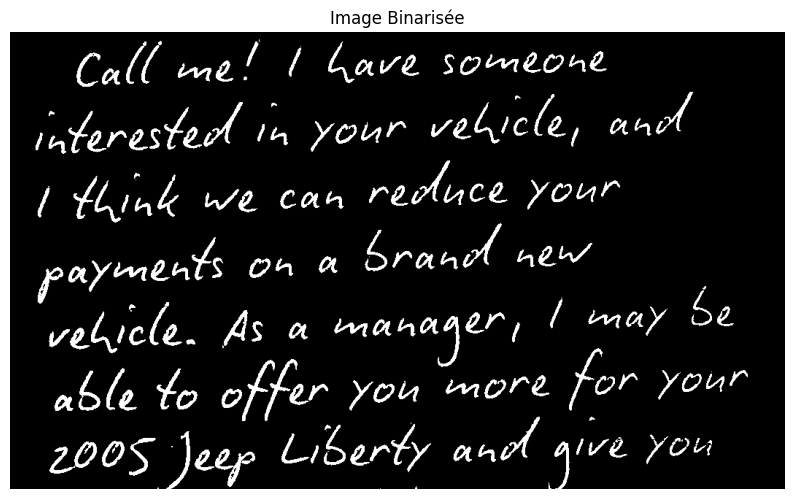

In [4]:
# Affichage de l'image originale
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.title("Image Originale")
plt.axis('off')
plt.show()


#filtrage médian pour réduire le bruit
image_filtre = cv2.medianBlur(image, 5)
plt.figure(figsize=(10, 6))
plt.imshow(image_filtre, cmap='gray')
plt.title("Image Filtré")
plt.axis('off')
plt.show()

# Normaliser l'image pour améliorer le contraste
image_norm = cv2.equalizeHist(image_filtre)
plt.figure(figsize=(10, 6))
plt.imshow(image_norm, cmap='gray')
plt.title("Image normalisé")
plt.axis('off')
plt.show()



# Binarisation de l'image
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.figure(figsize=(10, 6))
plt.imshow(binary_image, cmap='gray')
plt.title("Image Binarisée")
plt.axis('off')
plt.show()

# 2. Méthode de segmentation choisie : Croissance de régions 

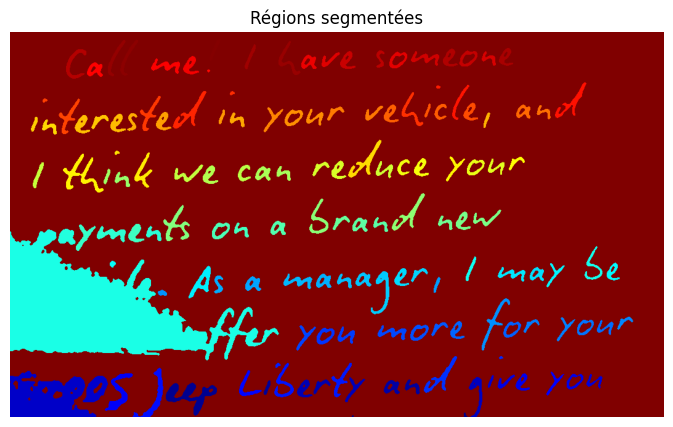

In [5]:
def croissance_regions(image, seuil=20, seuil_seed=20):

    h, w = image.shape
    visited = np.zeros((h, w), dtype=bool)
    regions = np.zeros((h, w), dtype=np.int32)
    region_id = 1

    for i in range(h):
        for j in range(w):
            # Condition pour qu'un pixel soit un seed
            if not visited[i, j] and image[i, j] <= seuil_seed:
                region_pixels = [(i, j)]
                intensite_seed = image[i, j]

                while region_pixels:
                    x, y = region_pixels.pop()

                    if not visited[x, y]:
                        visited[x, y] = True
                        regions[x, y] = region_id

                        # Vérifier les voisins
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nx, ny = x + dx, y + dy

                            if 0 <= nx < h and 0 <= ny < w:
                                if not visited[nx, ny]:
                                    # Vérifier la condition d'homogénéité
                                    if abs(int(image[nx, ny]) - int(intensite_seed)) <= seuil:
                                        region_pixels.append((nx, ny))

                region_id += 1

    return regions


#appliquer la croissance de régions
regions = croissance_regions(image_norm)

# générer une image colorée pour visualisation
region_colored = cv2.applyColorMap((regions * 255 // regions.max()).astype(np.uint8), cv2.COLORMAP_JET)

# afficher les régions
plt.figure(figsize=(10, 5))
plt.title("Régions segmentées")
plt.imshow(region_colored)
plt.axis("off")
plt.show()

# Étape 3 : Post-traitement

In [6]:
# Supprimer les régions trop petites et extraire des sous-images
def post_traitement(regions, min_size=50):
    unique_regions, counts = np.unique(regions, return_counts=True)
    filtered_regions = np.zeros_like(regions)

    for region, count in zip(unique_regions, counts):
        if count >= min_size:
            filtered_regions[regions == region] = region

    return filtered_regions


# Supprimer les régions trop petites
filtered_regions = post_traitement(regions)

# Extraire les boîtes englobantes
boites_englobantes = []
for region_id in np.unique(filtered_regions):
    if region_id == 0:
        continue

    y, x = np.where(filtered_regions == region_id)
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    boites_englobantes.append((x_min, y_min, x_max, y_max))

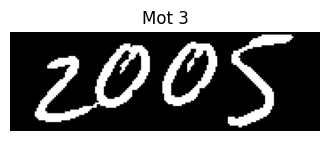

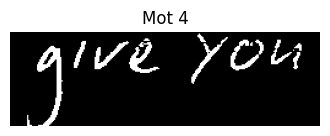

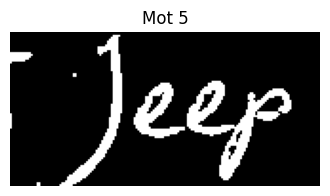

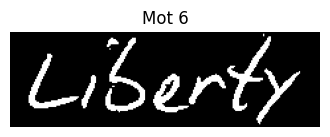

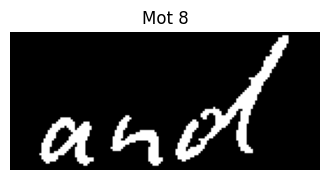

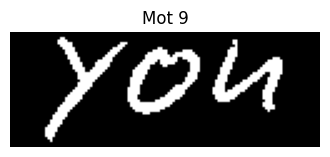

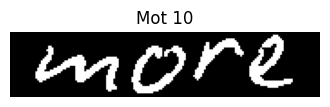

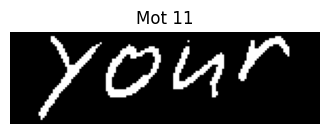

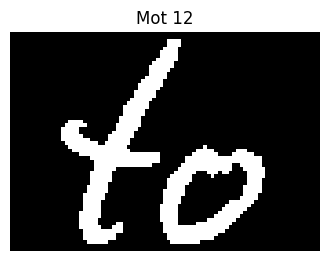

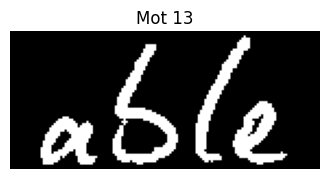

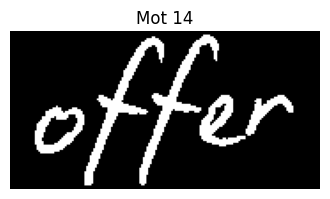

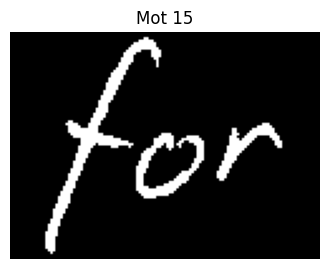

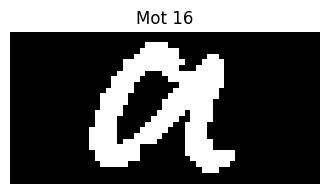

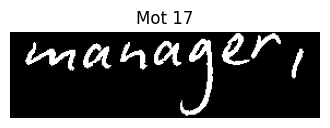

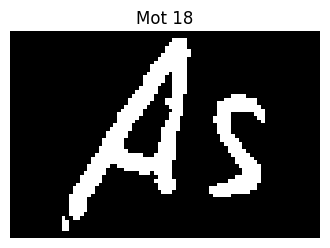

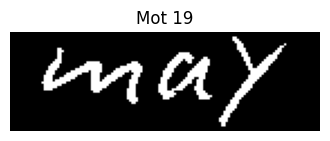

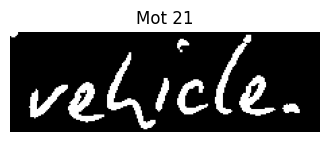

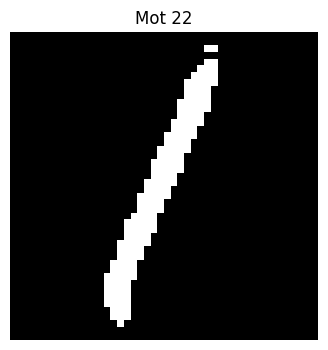

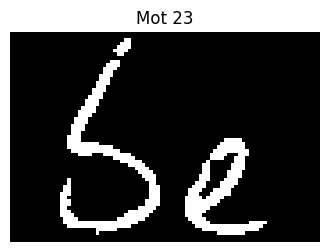

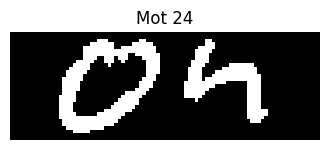

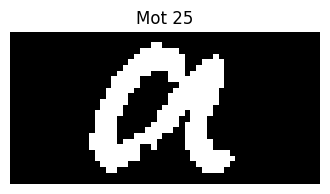

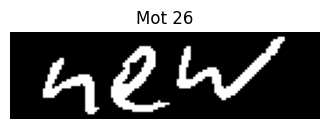

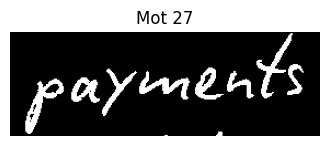

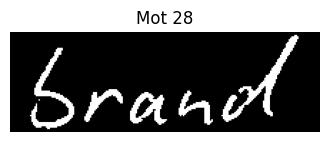

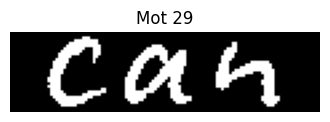

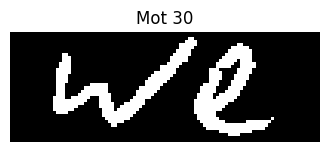

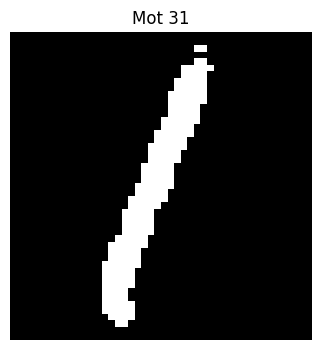

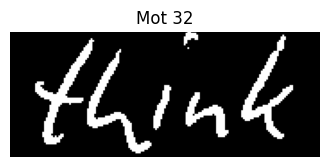

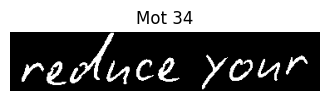

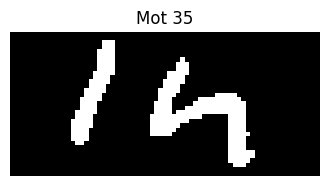

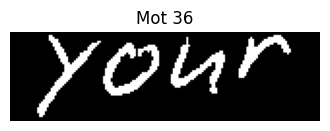

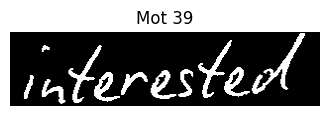

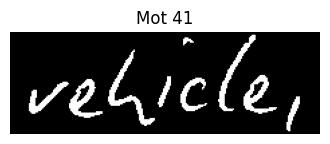

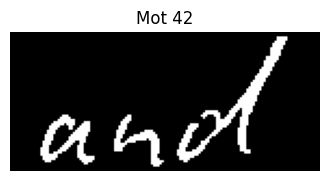

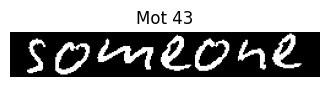

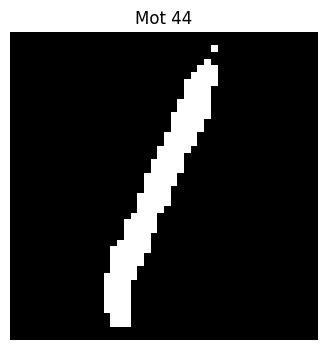

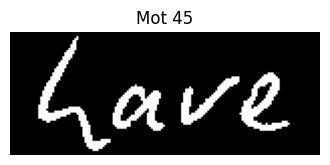

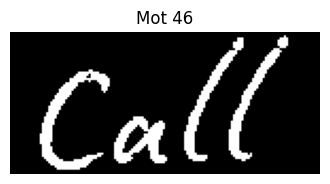

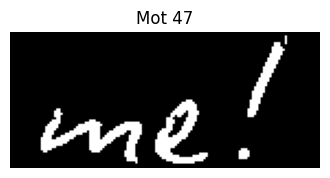

In [7]:
# Dilatation pour connecter les lettres d'un même mot
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))  # Taille ajustable
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

# Détection des contours
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
segmented_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Boucle pour dessiner les contours et extraire les mots
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    if w > 15 and h > 15:  # Ignorer les petits bruits
        cv2.rectangle(segmented_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        word_region = binary_image[y:y+h, x:x+w]
        
        # Afficher chaque mot segmenté
        plt.figure(figsize=(4, 4))
        plt.imshow(word_region, cmap='gray')
        plt.title(f"Mot {i+1}")
        plt.axis('off')
        plt.show()



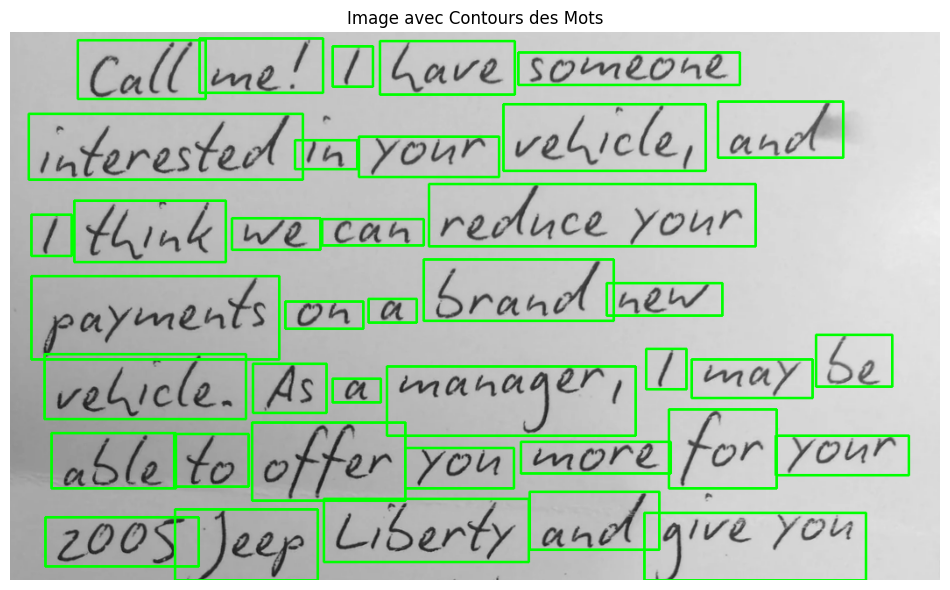

In [8]:

# Affichage de l'image avec les contours des mots
plt.figure(figsize=(12, 8))
plt.imshow(segmented_image)
plt.title("Image avec Contours des Mots")
plt.axis('off')
plt.show()